# Natural Events and climate change

In this project we will extract data from two sources:

1. EONET API v.2.1

2. Global carbon Atlas http://globalcarbonatlas.org/en/CO2-emissions

## Import Libraries

In [1]:

import pandas as pd
import numpy as np
import re
import math
import requests
import json
import matplotlib
%matplotlib inline
import seaborn as sns
from datetime import datetime

The natural events in the EONET's API are divided in two primarily groups according with their status:

* status = open means the natural event has not ended.

* status = close means the natural event has finished. When this happen we will have as well an aditional field labeled as closed.

## Extracting data from the EONET's API

In [18]:
def extract_cat(lista):
    return lista[0]["title"]

def extract_date(lista):
    return lista[0]["date"]

def extract_typ(lista):
    return lista[0]["type"]
    
def extract_coor(lista):
    return lista[0]["coordinates"]

def extract_geom(lista):
    del lista[0]["date"]
    return lista[0]
    
base = "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events?status=" 

def get_events(st):
    
    """
    Arguments: "open" or "closed"
    Returns a the data set of the events with status "st" 
    which happened since 1980-01-10 until teh current date.
    
    """
    url = base + f"{st}"
    result = requests.get(url)
    
    df_0 = pd.DataFrame(result.json()["events"], columns = ["id", "title", "categories", "description", "sources", "geometries", "closed"])
    df_0.categories = df_0.categories.apply(extract_cat) # Extract category from the original dictionary
    df_0["date"] = df_0.geometries.apply(extract_date)
    df_0["geometries"] = df_0.geometries.apply(extract_geom)
    df_0 = df_0.drop(columns = ["sources"])
    return df_0[['id', 'title', 'categories', 'description', 'date', 'closed','geometries']]




In [19]:
df_op = get_events("open")
df_cl = get_events("closed")

Let us explore our data frames:

In [20]:
df_op.head()

,id,title,categories,description,date,closed,geometries
0,EONET_4488,"Wildfires - Riverside County (Hill Fire), Cal...",Wildfires,,2019-10-30T16:02:00Z,NaN,"{'type': 'Point', 'coordinates': [-117.46421, ..."
1,EONET_4487,"Wildfires - Ventura County (Easy Fire), Califo...",Wildfires,,2019-10-30T13:23:00Z,NaN,"{'type': 'Point', 'coordinates': [-118.8304898..."
2,EONET_4485,Tropical Cyclone Maha,Severe Storms,,2019-10-30T08:46:01Z,NaN,"{'type': 'Point', 'coordinates': [74.8, 8.8]}"
3,EONET_4484,Tropical Storm Matmo,Severe Storms,,2019-10-30T00:00:00Z,NaN,"{'type': 'Point', 'coordinates': [111.9, 13.0]}"
4,EONET_4486,Subtropical Storm Rebekah,Severe Storms,,2019-10-30T00:00:00Z,NaN,"{'type': 'Point', 'coordinates': [-40.7, 38.3]}"


In [21]:
df_cl.head()

,id,title,categories,description,date,closed,geometries
0,EONET_4464,Typhoon Bualoi,Severe Storms,,2019-10-19T00:00:00Z,2019-10-30T00:00:00Z,"{'type': 'Point', 'coordinates': [155.1, 10.6]}"
1,EONET_4463,Tropical Storm Neoguri,Severe Storms,,2019-10-17T00:00:00Z,2019-10-27T00:00:00Z,"{'type': 'Point', 'coordinates': [129.9, 19.6]}"
2,EONET_4465,Tropical Storm Nestor,Severe Storms,,2019-10-17T00:00:00Z,2019-10-20T00:00:00Z,"{'type': 'Point', 'coordinates': [-95.2, 22.9]}"
3,EONET_4459,Tropical Cyclone Ema,Severe Storms,,2019-10-12T00:00:00Z,2019-10-19T00:00:00Z,"{'type': 'Point', 'coordinates': [-163.3, 19.6]}"
4,EONET_4460,Tropical Storm Melissa,Severe Storms,,2019-10-11T00:00:00Z,2019-10-14T00:00:00Z,"{'type': 'Point', 'coordinates': [-69.5, 38.2]}"


In [22]:
df_op.dtypes

id              object
title           object
categories      object
description     object
date            object
closed         float64
geometries      object
dtype: object

Now we want to concatenate both dataframes so we have all the information of events closed and open:

In [84]:
df_ev = pd.concat([df_op, df_cl], ignore_index=True).sort_values("date", ascending = False).reset_index(drop=True)

df_ev.dtypes

id             object
title          object
categories     object
description    object
date           object
closed         object
geometries     object
dtype: object

The columns "date" and "closed" have no suitable data type. We should correct this field. According with the documentation, most of the fields have Universal Time (UTC) as indicated by the letter Z. with this in mind, we will reformat these fields to YYYY-MM-DD:

In [85]:
df_ev["date"]= pd.to_datetime(df_ev['date'],infer_datetime_format = True).dt.date
df_ev["closed"]= pd.to_datetime(df_ev['closed'],infer_datetime_format = True).dt.date

In [86]:
df_ev["date"]= pd.to_datetime(df_ev['date'],infer_datetime_format = True)
df_ev["closed"]= pd.to_datetime(df_ev['closed'],infer_datetime_format = True)

In [87]:
df_ev.dtypes

id                     object
title                  object
categories             object
description            object
date           datetime64[ns]
closed         datetime64[ns]
geometries             object
dtype: object

Now we have a look to this dataframe:

In [622]:
df_ev.head(10)

,id,title,categories,date,closed,date_closed,geometries,year
0,EONET_4488,"Wildfires - Riverside County (Hill Fire), Cal...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-117.46421, ...",2019
1,EONET_4487,"Wildfires - Ventura County (Easy Fire), Califo...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-118.8304898...",2019
2,EONET_4485,Tropical Cyclone Maha,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [74.8, 8.8]}",2019
3,EONET_4484,Tropical Storm Matmo,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [111.9, 13.0]}",2019
4,EONET_4486,Subtropical Storm Rebekah,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-40.7, 38.3]}",2019
5,EONET_4482,Wildfires - Port Macquarie (Crestwood Drive Fi...,Wildfires,2019-10-28,False,NaT,"{'type': 'Point', 'coordinates': [152.18798676...",2019
6,EONET_4483,"Wildfires - La Ligua (La Patagua Fire), Chile",Wildfires,2019-10-28,False,NaT,"{'type': 'Point', 'coordinates': [-71.23004, -...",2019
7,EONET_4481,"Wildfires - Los Angeles County (Getty Fire), C...",Wildfires,2019-10-28,False,NaT,"{'type': 'Point', 'coordinates': [-118.4809553...",2019
8,EONET_4478,"Wildfires - San Diego County (Miller Fire), Ca...",Wildfires,2019-10-25,False,NaT,"{'type': 'Point', 'coordinates': [-117.03197, ...",2019
9,EONET_4477,"Wildfires - San Diego County (Sawday Fire), Ca...",Wildfires,2019-10-25,False,NaT,"{'type': 'Point', 'coordinates': [-116.74528, ...",2019


We have very little information in the "description" field (< 4%). Also, in order to do our analysis, this column in not relevant:

In [89]:
len(df_ev[df_ev["description"] != ""]) / len(df_ev)

0.039751838235294115

In [90]:
df_ev = df_ev.drop(columns = "description")

We now that the column "closed" only contains a date if the event is over. We will condense this information in an extra column with boolean values:

In [91]:
#Create a new column containing the date of end of the event

df_ev["date_closed"] = df_ev["closed"]

# Replace the column closed by a boolean column

df_ev["closed"] = (df_ev["date_closed"].notna())

In [92]:
#Rearranging the columns

df_ev = df_ev[['id', 'title', 'categories', 'date', 'closed', 'date_closed', 'geometries']]

In [623]:
df_ev.head(7)

,id,title,categories,date,closed,date_closed,geometries,year
0,EONET_4488,"Wildfires - Riverside County (Hill Fire), Cal...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-117.46421, ...",2019
1,EONET_4487,"Wildfires - Ventura County (Easy Fire), Califo...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-118.8304898...",2019
2,EONET_4485,Tropical Cyclone Maha,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [74.8, 8.8]}",2019
3,EONET_4484,Tropical Storm Matmo,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [111.9, 13.0]}",2019
4,EONET_4486,Subtropical Storm Rebekah,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-40.7, 38.3]}",2019
5,EONET_4482,Wildfires - Port Macquarie (Crestwood Drive Fi...,Wildfires,2019-10-28,False,NaT,"{'type': 'Point', 'coordinates': [152.18798676...",2019
6,EONET_4483,"Wildfires - La Ligua (La Patagua Fire), Chile",Wildfires,2019-10-28,False,NaT,"{'type': 'Point', 'coordinates': [-71.23004, -...",2019


In [94]:
df_ev.dtypes

id                     object
title                  object
categories             object
date           datetime64[ns]
closed                   bool
date_closed    datetime64[ns]
geometries             object
dtype: object

Now we export the data in a csv file:

In [626]:
df_ev.to_csv("natural_events.csv")

## CO2 Emissions data

Here we will access data contained in excel files. The data is available at http://globalcarbonatlas.org/en/CO2-emissions

### CO2 Emissions per country in Million tones

MtCO2 = 1 million tonnes of CO2
To convert between carbon dioxide (CO2) and carbon (C): 3.67 Mt CO2 = 1 Mt C.

In [510]:
emissions_mt = pd.read_excel("emissions_mtco2.xlsx")

,Year,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,1960,0.41388,2.0225,6.1512,NaN,0.54895,NaN,0.036640,48.7645,2.4936,...,4.3145,47.8515,NaN,57.0168,7.4839,NaN,NaN,3.6310,4.3552,5.9432
1,1961,0.49080,2.2790,6.0559,NaN,0.45371,NaN,0.047632,51.1267,2.5714,...,4.1168,49.3462,NaN,51.8798,7.9783,NaN,NaN,2.6637,3.7090,5.0613
2,1962,0.68859,2.4622,5.6610,NaN,1.17910,NaN,0.102590,53.6401,2.6987,...,4.0069,51.7895,0.040304,54.0561,9.3377,NaN,NaN,3.8838,3.5827,4.8890
3,1963,0.70674,2.0812,5.4192,NaN,1.14970,NaN,0.084272,50.0327,2.8942,...,4.3148,55.5408,0.032976,56.1517,9.1104,NaN,NaN,2.9165,3.4445,4.7004
4,1964,0.83855,2.0152,5.6430,NaN,1.22290,NaN,0.091600,55.6700,3.0780,...,4.5527,59.0674,0.062288,56.5500,11.7878,NaN,NaN,3.6310,3.2750,4.4691


### CO2 Emissions per country in kgCO2 per GDP

Carbon Intensity: Total CO2 emissions divided by GDP.
GDP: Gross Domestic Product, measured in US dollars (USD) at Purchasing Power Parity rates.


In [96]:
emissions_kg = pd.read_excel("emissions_kgco2.xlsx")

### CO2 Emissions in tonnes per person

CO2 emissions per person are measured as the total CO2 produced by a country as a consequence of human activities and are divided by the population of that country.

In [97]:
emissions_pc = pd.read_excel("emissions_tco2.xlsx")

### Land Use Emissions

Carbon dioxide emissions from land use, land use change and forestry (primarily deforestation). Global data values have an uncertainly of ±2 GtCO2 reported as ±1 sigma (68% chance that the real value lies within the given interval). Regional data generally have uncertainty of about ± 50%. For more information see: Section 2.2, Global Carbon Budget 2018, Le Quéré et al. 2018.



In [437]:
land_use = pd.read_excel("land_use_change.xlsx")

In [439]:
land_use.tail()

,Year,Canada,Caribbean,Central Africa,Central America & Mexico,China,East Africa,East Asia,Europe,Former Soviet Union,NonTropical S. America,North Africa & Middle East,Oceania,South Asia,Southeast Asia,Southern Africa,Tropical S. America,USA,West Africa
46,2006,7.196870,-7.839992,218.930914,149.754350,-309.245944,224.323979,-184.327952,-226.209992,-582.484050,79.874614,-9.718527,66.414155,-61.197984,2357.697915,393.177743,1447.225598,-113.428690,417.352400
47,2007,-46.266222,-7.317832,216.744695,139.780391,-336.326507,233.709637,-187.652238,-216.894431,-591.483257,78.329544,-12.347348,65.203055,-72.124675,1045.493085,377.957152,1395.327761,-117.242921,437.152050
48,2008,34.831236,-7.614832,217.405662,145.453477,-355.909994,238.631841,-157.393822,-206.673114,-585.464824,16.412240,-10.184617,83.234132,-70.922383,1120.381637,352.568826,1343.551768,-128.832414,448.851643
49,2009,10.059103,-6.930242,222.956537,132.376900,-371.934682,236.439016,-148.127072,-199.263751,-569.498489,41.513205,-9.121785,78.125492,-74.342456,1515.536042,337.959657,1291.377580,-139.325311,467.719113
50,2010,36.563843,-6.744795,216.767816,128.834616,-392.848911,231.682329,-159.471409,-177.081170,-542.885484,39.251017,-5.804839,96.917360,-73.795626,1164.185289,321.999561,1269.564935,-152.869446,486.457032


# Analysis Events per category and year

In [99]:
df_ev.categories.value_counts()

Severe Storms           1792
Wildfires               1459
Volcanoes                847
Floods                   116
Sea and Lake Ice          58
Dust and Haze             17
Water Color               17
Earthquakes               15
Temperature Extremes      14
Drought                    7
Manmade                    5
Snow                       3
Landslides                 2
Name: categories, dtype: int64

In [110]:
#Extracting the year for each entry of the data set. We want the information year by year

df_ev["year"]= df_ev["date"].dt.year

In [236]:
events_per_year_cat = df_ev.groupby(["year", 'categories'])[["id"]].count()
events_per_year_cat.columns = ["no_of_events"]
#data.groupby(['month', 'item'])['date'].count()

In [540]:
from matplotlib import pyplot as plt

In [545]:
events_year = df_ev.groupby(["year"])[["id"]].count().reset_index()

In [549]:
events_year.columns= ["Year", "Number_of_events"]

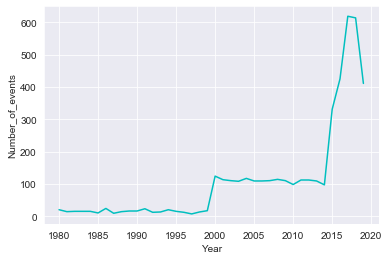

In [606]:
#sns.set('figure.facecolor':'black')
sns.set_style("darkgrid")
sns.lineplot(x="Year", y="Number_of_events", data=events_year, color="c")


In [238]:
events_year2000 = df_ev[df_ev["year"] >= 2000].groupby(["year"])[["id"]].count()

#imag_1.legend(loc='lower right', bbox_to_anchor=(1.2, 0.5), bbox_transform=plt.gcf().transFigure)

In [239]:
events_year2000= events_year2000.reset_index()

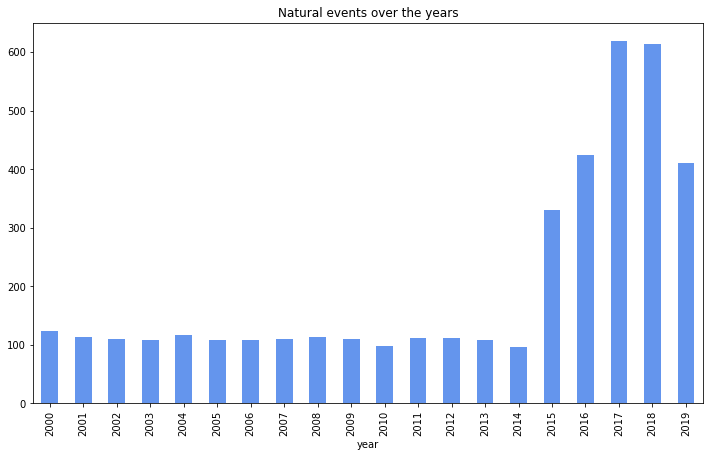

In [315]:
#gca stands for 'get current axis'
ax = plt.gca()

events_year2000.plot(kind='bar',x='year',y='id',ax=ax, title = "Natural events over the years", legend= False, color = "cornflowerblue", figsize= (12,7))

plt.show()

events_year2000.plot(kind='bar',x='year',y='id',ax=ax, title = "Natural events over the years", legend= False, color = "cornflowerblue", figsize= (12,7)).get_figure().savefig('fig01.png')


In [597]:
events_year2000.plot(kind='line',x='year',y='id',ax=ax, title = "Natural events over the years", legend= False, color = "cornflowerblue", figsize= (12,7)).get_figure().savefig('fig01.png')


In [313]:
events_year2000_cat = df_ev[df_ev["year"] >= 2000].groupby(["year", 'categories'])[["id"]].count()

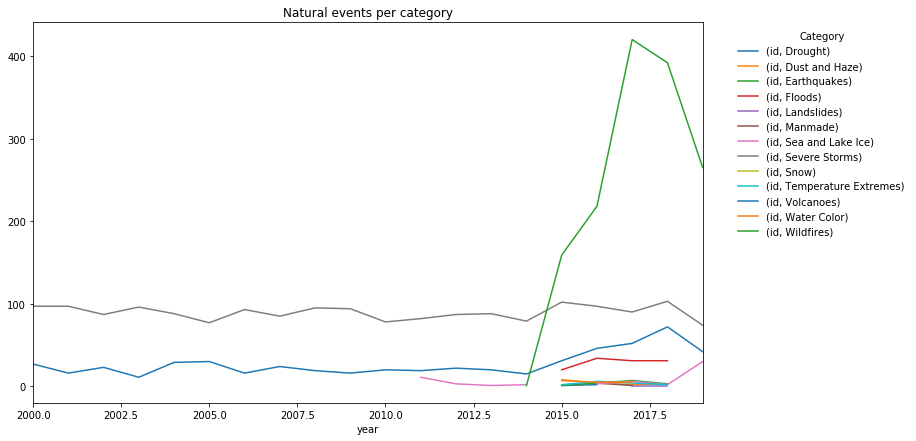

In [322]:
#fig, ax = plt.subplots()
#lines = ax.plot(events_year2000_cat.unstack())
#ax.legend(['Drought', 'Dust and Haze', 'Earthquakes', 'Floods', 'Landslides', 'Manmade', 'Sea and Lake Ice', 'Severe Storms', 'Snow', 'Temperature Extremes', 'Volcanoes', 'Water Color', 'Wildfires'])
events_year2000_cat.unstack().plot(title = "Natural events per category", figsize=(12,7)).legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon= False, title = "Category").get_figure().savefig('fig_02.png')

In [323]:
#fig.get_figure().savefig('output.png')

events_year2014_cat = df_ev[df_ev["year"] >= 2014].groupby(["year", 'categories'])[["id"]].count()

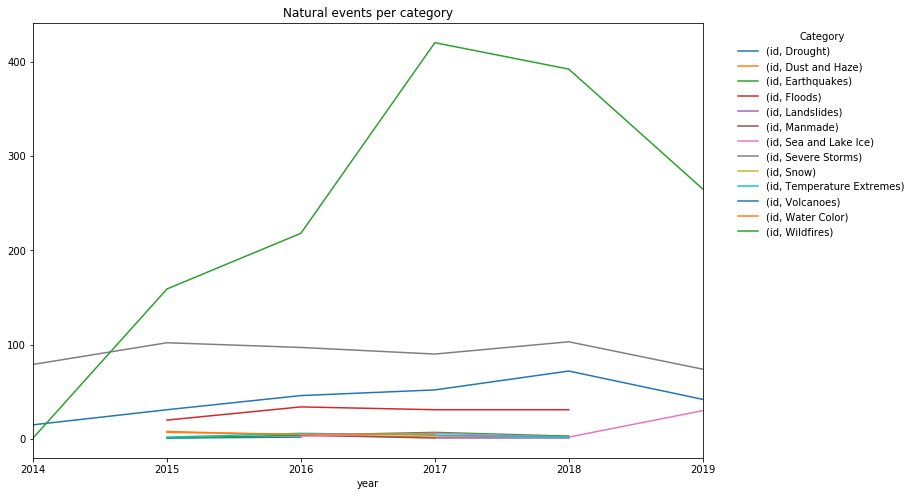

In [324]:
events_year2014_cat.unstack().plot(title = "Natural events per category", figsize=(12,8)).legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon= False, title = "Category").get_figure().savefig('fig_03.png')

In [342]:
last_6_years_events= df_ev[df_ev["year"] >= 2013].groupby(['categories'])[["id"]].count().reset_index().sort_values("id", ascending= False);
last_6_years_events.columns= ["Categories", "no_of_ocurrences"]

These are the most frequent natural events over the last 5 years:

In [354]:
top_5= last_6_years_events.head(5)

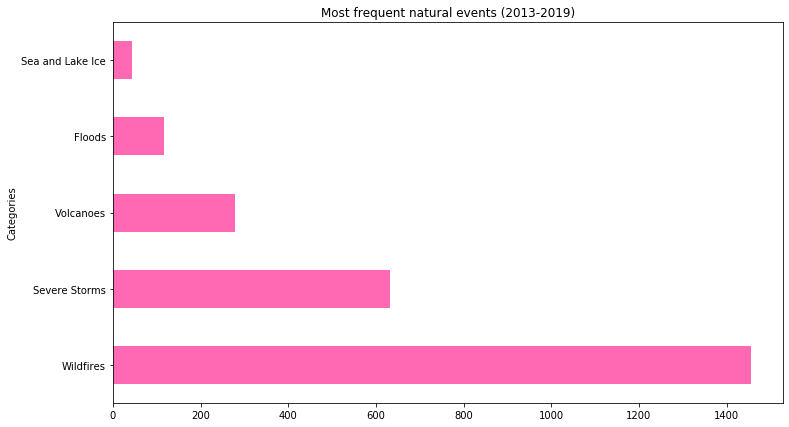

In [396]:
top_5.plot(kind= "barh", x= "Categories", y= "no_of_ocurrences", legend= False, title= "Most frequent natural events (2013-2019)", color= "hotpink",  figsize=(12,7)).get_figure().savefig('fig_04.png')

We will create a heatmap to see the overall distribution of natural events along the years. First we group and aggregate the information in the next dataframe:

In [390]:
by_cat = (df_ev[df_ev["year"]>=2000]
            .groupby(['categories', "year"])
            .size()
            .unstack()
           )

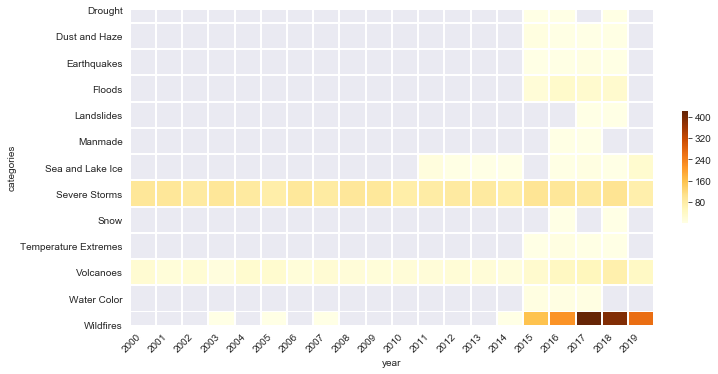

In [638]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_cat, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap= "YlOrBr", # use orange/red colour map'YlOrBr'
    linewidth=1 # space between cells
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

In [639]:
g.get_figure().savefig("heatmap.png")

In [401]:
df_ev.head()

,id,title,categories,date,closed,date_closed,geometries,year
0,EONET_4488,"Wildfires - Riverside County (Hill Fire), Cal...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-117.46421, ...",2019
1,EONET_4487,"Wildfires - Ventura County (Easy Fire), Califo...",Wildfires,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-118.8304898...",2019
2,EONET_4485,Tropical Cyclone Maha,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [74.8, 8.8]}",2019
3,EONET_4484,Tropical Storm Matmo,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [111.9, 13.0]}",2019
4,EONET_4486,Subtropical Storm Rebekah,Severe Storms,2019-10-30,False,NaT,"{'type': 'Point', 'coordinates': [-40.7, 38.3]}",2019


In [412]:
by_cat_total= df_ev.groupby(["year", "categories"])[["id"]].count().reset_index()

In [414]:
by_cat_total.columns = ["year", "category", "frequency"]

In [418]:
by_year_total= by_cat_total.groupby("year").sum().reset_index()

In [511]:
emissions_mt.head()

,Year,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,1960,0.41388,2.0225,6.1512,NaN,0.54895,NaN,0.036640,48.7645,2.4936,...,4.3145,47.8515,NaN,57.0168,7.4839,NaN,NaN,3.6310,4.3552,5.9432
1,1961,0.49080,2.2790,6.0559,NaN,0.45371,NaN,0.047632,51.1267,2.5714,...,4.1168,49.3462,NaN,51.8798,7.9783,NaN,NaN,2.6637,3.7090,5.0613
2,1962,0.68859,2.4622,5.6610,NaN,1.17910,NaN,0.102590,53.6401,2.6987,...,4.0069,51.7895,0.040304,54.0561,9.3377,NaN,NaN,3.8838,3.5827,4.8890
3,1963,0.70674,2.0812,5.4192,NaN,1.14970,NaN,0.084272,50.0327,2.8942,...,4.3148,55.5408,0.032976,56.1517,9.1104,NaN,NaN,2.9165,3.4445,4.7004
4,1964,0.83855,2.0152,5.6430,NaN,1.22290,NaN,0.091600,55.6700,3.0780,...,4.5527,59.0674,0.062288,56.5500,11.7878,NaN,NaN,3.6310,3.2750,4.4691


In [512]:
emissions_mt["mt_CO2_global"]= emissions_mt.sum(axis = 1, skipna = True)
emissions_kg["kg_CO2_global"]= emissions_kg.sum(axis = 1, skipna = True)
emissions_pc["pc_CO2_average"]= emissions_pc.mean(axis = 1, skipna = True)

In [517]:
aux_mt = emissions_mt[["Year", "mt_CO2_global"]]
aux_kg = emissions_kg[["Year", "kg_CO2_global"]]
aux_pc = emissions_pc[["Year", "pc_CO2_average"]]

In [519]:
emissions_combined = pd.merge(aux_mt, aux_kg, on= "Year")

In [522]:
emissions_combined = pd.merge(emissions_combined, aux_pc, on ="Year")

In [624]:
emissions_combined.head(10)

,Year,mt_CO2_global,kg_CO2_global,pc_CO2_average
0,1960,11064.131248,3920.0,13.719937
1,1961,11061.885846,3922.0,13.804837
2,1962,11385.687956,3924.0,13.838856
3,1963,11923.171792,3926.0,14.295206
4,1964,12430.081615,3928.0,14.307196
5,1965,12921.535815,3930.0,14.340537
6,1966,13420.870930,3932.0,14.305202
7,1967,13774.912094,3934.0,14.508391
8,1968,14419.554844,3936.0,14.637909
9,1969,15257.565529,3938.0,15.346885


In [627]:
#Save the dataframe as csv
emissions_combined.to_csv("emissions_CO2.csv")

In [625]:
emissions_events= pd.merge(emissions_combined, events_year, on = "Year")
emissions_events.head(10)

,Year,mt_CO2_global,kg_CO2_global,pc_CO2_average,Number_of_events
0,1980,20928.866204,4054.845970,15.560998,20
1,1981,20439.839034,4053.400998,14.956099,14
2,1982,20341.079622,4056.926502,14.889520,15
3,1983,20530.671032,4050.300670,14.484301,15
4,1984,21080.674356,4062.019382,15.006519,15
5,1985,21768.494488,4068.839102,15.250024,10
6,1986,22035.509136,4054.344036,14.603545,24
7,1987,22739.156532,4056.015335,14.639604,9
8,1988,23536.523416,4057.716957,14.797980,14
9,1989,23866.218532,4062.961496,15.035768,16


In [628]:
#Save the dataframe as csv
emissions_events.to_csv("emissions_events.csv")

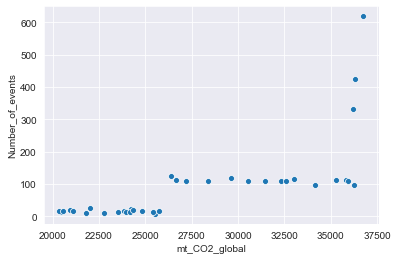

In [611]:
sns.scatterplot(x= "mt_CO2_global", y= "Number_of_events", data=emissions_events);

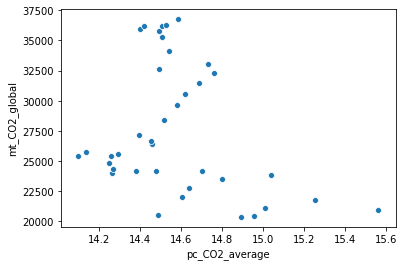

In [559]:
sns.scatterplot(x= "pc_CO2_average" , y= "mt_CO2_global", data=emissions_events);

In [472]:
emissions_mt[emissions_mt["Year"]>=2000].transpose().reset_index();

In [449]:
df_1= emissions_mt[emissions_mt["Year"]>=2000].transpose()

In [450]:
df_1.columns= [str(2000+i) for i in range(18)]

In [456]:
df_1 = df_1.reset_index()

In [460]:
df_1= df_1.drop(df_1.index[0])

In [465]:
df_1.rename(columns={'Year':'Country'}, inplace=True)

In [466]:
df_1.head()

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,Afghanistan,0.76820,0.81207,1.06410,1.18710,0.94146,1.32030,1.64320,2.26830,4.19830,6.76030,8.45220,12.22600,10.74210,10.00040,9.78920,10.10740,12.25790,13.01470
2,Albania,3.01910,3.22070,3.74830,4.29050,4.16230,4.25020,3.89480,3.92410,4.37120,4.37480,4.59470,5.23590,4.90610,5.06000,5.71220,5.94770,6.27290,6.37920
3,Algeria,87.44270,83.78070,89.40670,91.04820,87.85310,106.47320,100.20120,108.40000,109.03180,120.18590,117.81410,119.80690,128.11000,132.43460,143.17710,150.59250,150.37800,150.55140
4,Andorra,0.52395,0.52395,0.53128,0.53494,0.56059,0.57525,0.54594,0.53861,0.53861,0.51662,0.51662,0.49098,0.48731,0.47632,0.46166,0.47724,0.51151,0.52018
5,Angola,9.51510,9.67150,12.59750,8.98840,18.70190,19.00640,22.10240,24.97610,25.48600,27.56550,28.86450,30.14210,33.18580,32.37310,34.45760,34.76110,35.35100,35.38990


In [506]:
def clean_data(data, n):
    data0 = data[data["Year"] >= n].transpose().reset_index()
    data0 = data0.drop(data0.index[0])
    a = 2017-n+1
    data0.columns= ["Country"]+[str(n+i) for i in range(a)]
    return data0
    

In [508]:
emissions_mt_2000 = clean_data(emissions_mt, 2000);
emissions_mt_2000 = clean_data(emissions_mt, 2000);

In [527]:
data_2017_country = clean_data(emissions_mt,2017)

In [529]:
data_2017_country.columns= ["Country", "emissions_mt"]

In [532]:
data_2017_country = pd.merge(data_2017_country, clean_data(emissions_kg, 2017), on = "Country")

In [533]:
data_2017_country.columns= ["Country", "emissions_mt", "emissions_kg"]

In [534]:
data_2017_country = pd.merge(data_2017_country, clean_data(emissions_pc, 2017), on = "Country")

In [535]:
data_2017_country.columns= ["Country", "emissions_mt", "emissions_kg", "emissions_per_capita"]

In [536]:
data_2017_country.head()

,Country,emissions_mt,emissions_kg,emissions_per_capita
0,Afghanistan,13.01470,0.000000,0.366301
1,Albania,6.37920,0.199077,2.177062
2,Algeria,150.55140,0.266563,3.643712
3,Andorra,0.52018,0.000000,6.758657
4,Angola,35.38990,0.208277,1.188211


In [538]:
data_2017_country.describe()

,emissions_mt,emissions_kg,emissions_per_capita
count,212.000000,212.000000,212.000000
mean,163.870270,0.171206,5.140073
std,797.721388,0.185137,6.584466
min,0.011696,0.000000,0.048705
25%,1.361725,0.000000,0.868869
50%,9.688750,0.139946,2.844043
75%,63.235250,0.260384,6.839280
max,9838.754000,1.113397,49.182616


In [629]:
data_2017_country= data_2017_country.sort_values("emissions_mt", ascending= False)

In [630]:
data_2017_country.to_csv("emissions_CO2_2017.csv")

/Users/Fabi/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Fabi/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


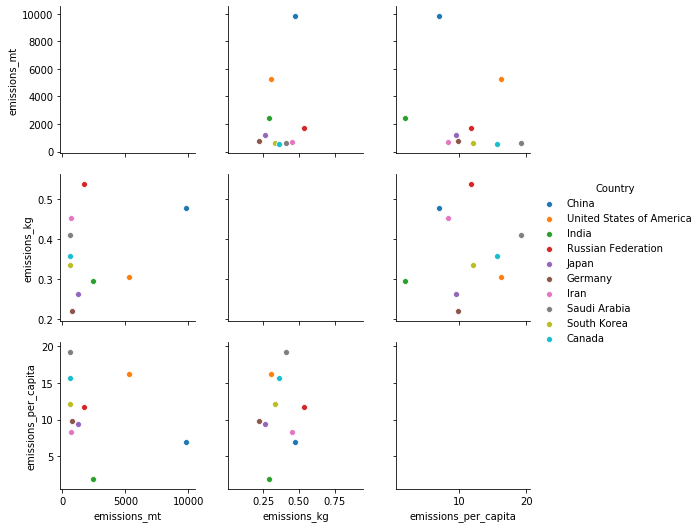

In [596]:
sns.pairplot(data = data_2017_country.sort_values("emissions_mt", ascending= False).head(10), hue = "Country");

In [576]:
#sns.pairplot(data = data_2017_country[["Country", "emissions_per_capita", "emissions_mt"]].sort_values("emissions_mt", ascending= False).head(10), hue = "Country")

In [579]:
top_10= data_2017_country[["Country", "emissions_per_capita", "emissions_mt"]].sort_values("emissions_mt", ascending= False).head(10)

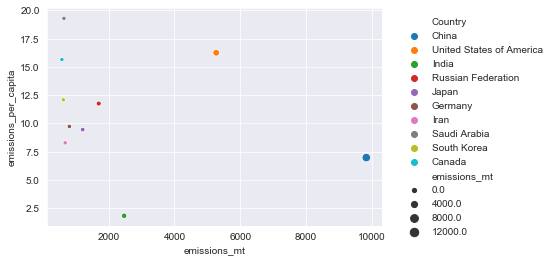

In [621]:
sns.scatterplot(data= top_10, y= "emissions_per_capita", x = "emissions_mt", hue= "Country", size="emissions_mt").legend(bbox_to_anchor=(1.04,1), loc="upper left",frameon= False);

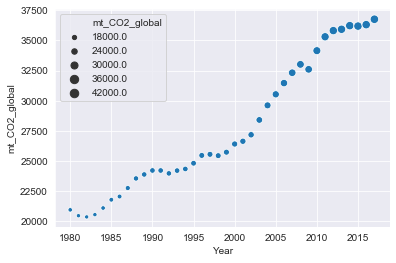

In [619]:
plot5= sns.scatterplot(data= emissions_events, y= "mt_CO2_global", x = "Year", size="mt_CO2_global");